## General notation:
$L=$ length of a protein sequence

$M=$ number of sequences

$N=$ number of amminoacids consideres (in our case $N=21$)

# THE GENERATIVE MODEL
## Generalized Pott's model
The most general generative model we can consider is the **generalized Pott's model** in which the energy of a sequence is $\mathbf{a}=(a_1,...,a_L)$ is given by:
$$H(a_1,...,a_L)=-\sum_{i=1}^L h_i(a_i)-\sum_{i<j}J_{i,j}(a_i,a_j)$$
This model defines the probability of a sequence as:\n",
$$P(\mathbf{a})=P(a_1,...,a_L)\propto \exp\big[-H(a_1,...,a_L)\big]$$
The inference of the model amounts to determining from the data the functions $\{h_i(a_i)\}$ and $\{J_{i,j}(a_i,a_j)\}$. In our case in which we have sequences of length $L=96$ and 21 possible values for the $a_i$ (20 amminoacids + 1 blank character) this amounts to inferring the value of:
$$96\times 21+\frac{96\times 95}{2}\times \frac{21^2}{2}\sim 10^6$$
different parameters.

## Random fiels Ising model
We can reduce the computational time and avoid overfitting by reducing the complexity of the model. If we consider the frequencies of observed amminoacids in each position:
$$f_i(a)=\frac{1}{M}\sum_{m=1}^M \delta_{a,a_i^m}$$
We can define for each site a **consensus amminoacid** give by:
$$A_i\equiv \underset{a}{\operatorname{\text{argmax}}} f_i(a)$$
Using this we can *binarize* our data introducing Ising variables given by:
$$
s_i = \begin{cases}
    +1 & \text{if } a_i = A_i \\
    -1 & \text{otherwise.}
\end{cases}
$$
For this dataset we can learn a Random field Ising model, in which the energy is give by:
$$H\big(\{s_i\}\big)=-\sum_{i=1}^L h_is_i-J\sum_{i<j}s_is_j$$
In this case we just have to infer the value of:
$$L+1=96+1=97$$
parameters.

From this model to sample protein sequences we sample spin configurations and then:
$$
a_i = \begin{cases}
    A_i & \text{if } s_i = +1 \\
    b & \text{with probability } \frac{f_i(b)}{\sum_{c\neq A_i} f_i(c)} & \text{if } s_i = -1
\end{cases}
$$

# Procedure to learn the parameters\n",
1. Compute the empirical (or "target") marginals:
$$\hat{g}_i=\frac{1}{M}\sum_{m=1}^M s_i$$
$$\hat{l}=\frac{1}{M\times \frac{L(L-1)}{2}}\sum_{m=1}^M \sum_{i<j}s_is_j$$
2. Start with randomly initialized parameters $\{h_i\}$ and $J$
3. Calculate the single and double "marginals":
$$g_i=\langle s_i\rangle_P=\sum_{\{s_k\}}P\big(\{s_k\}\big)s_i$$
$$l=\langle \frac{1}{\frac{L(L-1)}{2}}\sum_{i<j}s_is_j\rangle_P=\sum_{\{s_k\}}P\big(\{s_k\}\big)\frac{1}{\frac{L(L-1)}{2}}\sum_{i<j}s_is_j$$
4. Update the model parameters in order to match the target marginals:
$$h_i(a)\leftarrow h_i+\epsilon\big(\hat{g}_i-g_i)$$
$$J\leftarrow J+\epsilon\big(\hat{l}-l\big)$$

Points 3-4 are iterated until we have some kind of convergence:
$$\big|\hat{g}_i-g_i\big|<\alpha\text{ } \forall i \wedge \big|\hat{l}-l\big|<\alpha$$

One way to reduce the computational cost would be by using MCMC to compute the averages $\langle s_i\rangle_P$ and $\langle\frac{1}{\frac{L(L-1)}{2}}\sum_{i<j}s_is_j\rangle_P$, we will also need to introduce **regularization** (pseudocount or $L_2$ regularization to account for unobserved configuarations that.

In [46]:
import pandas as pd
import numpy as np
from numba import jit
import math
import random

In [47]:
@jit
def delta(a,b):
    if a == b:
        return 1
    else:
        return 0

In [48]:
#functions to open the file and integer encode the sequences

def integer_encode_seq(sequence): #we can use instead of this the one-hot encoded function
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    return integer_encoded

def integer_encode_fasta_file(path_to_file):
    y = []
    X = []
    with open(path_to_file) as f:
        for line in f:
            line = line.strip() #removes blank spaces at the beginning and at the end of each line
            if not line:
                continue #does nothing if the line is empty
            if line.startswith(">"): #handles a label line
                text_sequence = '' #initializes the string in which we will store our sequence - trick to avoid messing up the two line sequence :)
                if line.endswith("true"):
                    y.append(1)
                elif line.endswith("false"):
                    y.append(0)
            else: #case in which we have the first line of a sequence or the second line of a sequence
                if len(text_sequence) == 0:
                    text_sequence = text_sequence + line
                else:
                    text_sequence = text_sequence + line
                    X.append(integer_encode_seq(text_sequence))
    return np.array(y), np.array(X)

In [49]:
y, X = integer_encode_fasta_file('MSA_nat_with_annotation.faa')

In [50]:
#general parameters
L = len(X[1])
print("length of the sequences, L = ", L)
M = len(X)
print("number of sequences, M = ", M)
N = 21
print("number of characters/AAs, N = ", N)

length of the sequences, L =  96
number of sequences, M =  1130
number of characters/AAs, N =  21


In [51]:
@jit
def f(a, i, X):
    tot = 0
    for m in range(M):
        tot = tot+delta(a, X[m,i])
    return tot/M

@jit
def A(i, X):
    f_array = []
    for a in range(N):
        F = f(a, i, X)
        f_array.append(F)
    f_array = np.array(f_array)
    return np.argmax(f_array)

In [52]:
#trasformation to Ising
@jit
def ising_transform(X):
    X_ising = X.copy()
    for m in range(len(X)):
        for i in range(L):
            if X[m,i] == A(i, X):
                X_ising[m,i] = 1
            else:
                X_ising[m,i] = -1
    return X_ising

In [53]:
X_ising = ising_transform(X)

In [54]:
#energy function
@jit
def energy(h_array, J, sequence):
    energy = 0
    for i in range(len(sequence)):
        energy -= h_array[i]*sequence[i]
    for i in range(len(sequence)-1):
        for j in range(i, len(sequence)):
            energy -= J*sequence[i]*sequence[j]
    return energy

**STEP 1:** compute the target parameters

In [55]:
#compute \hat{g}_i
@jit
def hat_g_i(data, i):
    result = 0
    for m in range(len(data)):
        result += data[m,i]
    return result/len(data)

#compute \hat{l}
@jit
def hat_l(data):
    L=len(data[0])
    result = 0
    for m in range (len(data)):
        for i in range(L-1):
            for j in range(i,L):
                result += data[m,i]*data[m,j]
    denominator = len(data)*L*(L-1)/2
    return result/denominator

In [11]:
# RUN this for have the convergence without pseudocount
g_i_hat_array = np.array([hat_g_i(X_ising, i) for i in range(L)])
l_hat = hat_l(X_ising)
print("g_i_hat:")
print(g_i_hat_array)
print("l_hat:")
print(l_hat)

g_i_hat:
[-0.13451327 -0.24424779 -0.37345133 -0.52035398 -0.70973451 -0.6460177
  0.35044248 -0.63539823 -0.50088496 -0.16637168  0.79292035 -0.68849558
 -0.53628319  0.49734513  0.42123894 -0.61946903 -0.19646018  0.63716814
 -0.65309735 -0.48849558  0.04070796 -0.30619469 -0.64778761  0.40176991
  0.16460177 -0.40176991 -0.20884956  0.99469027 -0.50088496 -0.69026549
 -0.34513274 -0.43893805 -0.67256637 -0.52035398 -0.08141593 -0.01946903
 -0.55752212 -0.51681416  0.79469027 -0.62831858 -0.64070796 -0.67433628
 -0.21769912 -0.4460177  -0.10619469 -0.29557522 -0.61415929  0.06548673
  0.00530973 -0.56106195  0.7699115   0.51150442 -0.61769912 -0.43185841
 -0.28318584 -0.03893805 -0.50973451 -0.31327434 -0.40884956 -0.52212389
 -0.6159292  -0.5699115  -0.13628319 -0.57699115 -0.55575221 -0.72389381
  0.07610619  0.57876106 -0.07610619 -0.39469027 -0.41769912 -0.54513274
 -0.61415929 -0.4300885  -0.43539823 -0.69557522 -0.44070796 -0.14690265
 -0.49734513 -0.67079646 -0.05840708 -0.332

We can introduce a regularization by mean of a pseudocount:
$$ 
\hat{g}_i \leftarrow (1-\beta)\hat{g}_i+\frac{\beta}{M}
$$

In [56]:
# RUN this for pseudocount
beta = 0.3
g_i_hat_array = np.array([(1-beta)*hat_g_i(X_ising, i)+beta/M for i in range(L)])
l_hat = hat_l(X_ising)
print("g_i_hat:")
print(g_i_hat_array)
print("l_hat:")
print(l_hat)

g_i_hat:
[-0.09389381 -0.17070796 -0.26115044 -0.3639823  -0.49654867 -0.4519469
  0.24557522 -0.44451327 -0.35035398 -0.11619469  0.55530973 -0.48168142
 -0.37513274  0.34840708  0.29513274 -0.43336283 -0.13725664  0.44628319
 -0.45690265 -0.34168142  0.02876106 -0.2140708  -0.45318584  0.28150442
  0.11548673 -0.28097345 -0.1459292   0.69654867 -0.35035398 -0.48292035
 -0.24132743 -0.30699115 -0.47053097 -0.3639823  -0.05672566 -0.01336283
 -0.39       -0.36150442  0.55654867 -0.43955752 -0.44823009 -0.47176991
 -0.15212389 -0.3119469  -0.0740708  -0.20663717 -0.42964602  0.04610619
  0.0039823  -0.39247788  0.53920354  0.35831858 -0.43212389 -0.3020354
 -0.1979646  -0.02699115 -0.35654867 -0.21902655 -0.2859292  -0.36522124
 -0.43088496 -0.39867257 -0.09513274 -0.40362832 -0.38876106 -0.50646018
  0.05353982  0.40539823 -0.05300885 -0.2760177  -0.29212389 -0.38132743
 -0.42964602 -0.30079646 -0.30451327 -0.48663717 -0.30823009 -0.10256637
 -0.34787611 -0.46929204 -0.04061947 -0.2326

**STEPS 2-3-4**: Learning the parameters

In [57]:
@jit
def trial(sequence): #select 3 spins at random and flip it
    new_sequence = np.copy(sequence)
    for i in range(1):
        p = random.randint(0, len(sequence)-1)
        new_sequence[p] *= -1
    return new_sequence

def MC_sampling(h_array, J, L, n_steps, sequence_zero): #USE np.array() for h ELSE JIT DOES NOT WORK
    #compute energy of the randomly initialized sequence
    energy_zero = energy(h_array, J, sequence_zero)
    #array to store my sample
    sample = []
    for i in range(n_steps):
        #propose a move by flipping one of the spins
        sequence_new = trial(sequence_zero)
        #compute energy of the proposed sequence
        energy_new = energy(h_array, J, sequence_new)
        alpha = np.exp(-energy_new/83)/np.exp(-energy_zero/83)
        if alpha > 1:
            alpha = 1
        if alpha > random.random(): #to accept with a probability equal to the acceptance
            #update the sequence
            sequence_zero = np.copy(sequence_new)
            energy_zero = energy_new
            #update sample
            sample.append(sequence_zero)
        else:
            sample.append(sequence_zero)
    return np.array(sample), sequence_zero

In [58]:
def run_with_p(step_max, g_i_hat_array, l_hat, L, n_MC, eps, alpha):
    print("Process: STARTED")
    h_array = np.array([random.uniform(-2.5, 2.5) for i in range(L)])
    J = random.uniform(0., 2)
    sequence_zero = X_ising[0]
    #sequence_zero = np.array([random.randrange(-1,2,2) for i in range(L)])
    s, seq = MC_sampling(h_array, J, L, n_MC, sequence_zero)
    g_i_array = np.array([hat_g_i(s, i) for i in range(L)])
    l = hat_l(s)
    #util to check if convergence occurred
    score = 0
    #step counter
    steps_done = 1
    while(score != len(h_array)+1 and steps_done < step_max):
        score = 0
        h_array = h_array+eps*(g_i_hat_array-g_i_array)
        J = J+eps*(l_hat-l)
        s, seq = MC_sampling(h_array, J, L, n_MC, seq)
        g_i_array = np.array([hat_g_i(s, i) for i in range(L)])
        l = hat_l(s)
        for i in range(len(g_i_hat_array)):
            if abs(g_i_hat_array[i]-g_i_array[i]) < alpha:
                score += 1
        if abs(l-l_hat) < alpha:
            score +=1
        steps_done += 1
        if (steps_done/step_max*100%1)==0:
            print(steps_done/step_max*100,"%")
            print("  step: ", steps_done,"/",step_max)
            print("  Converged parameters: ", score, "/", len(h_array)+1)
    print("Process: DONE")
    return h_array, J

In [59]:
h_array = np.array([np.arctan(g_i_hat_array[i])*83 for i in range(L)])
J = 0.
step_max = 100000
n_MC = 100000
epsilon = 0.5
alpha = 0.05

In [60]:
print(h_array)

[ -7.77040453 -14.03348692 -21.20196432 -28.97334995 -38.25326718
 -35.23115872  19.9872175  -34.71738978 -27.97018131  -9.60110494
  42.07358315 -37.25750803 -29.78762456  27.82616769  23.81979329
 -33.94141109 -11.32155752  34.83997418 -35.57208419 -27.32732828
   2.38651025 -17.50369087 -35.31650937  22.77546644   9.54312195
 -22.73462594 -12.02722877  50.497688   -27.97018131 -37.34093386
 -19.6543784  -24.72223797 -36.50304324 -28.97334995  -4.70318977
  -1.10904903 -30.86405413 -28.79160128  42.15213729 -34.37329675
 -34.97463062 -36.58719488 -12.5302158  -25.09761467  -6.13666957
 -16.91284614 -33.68133987   3.82410596   0.33052923 -31.04241628
  41.04486219  28.55750108 -33.85479884 -24.34581602 -16.22132763
  -2.2397217  -28.42724039 -17.89659315 -23.11536266 -29.06411589
 -33.7681084  -31.48700568  -7.87232593 -31.8413165  -30.7747607
 -38.91059791   4.43956652  31.96756154  -4.39562045 -22.35290524
 -23.58988135 -30.23743426 -33.68133987 -24.25154852 -24.53415696
 -37.590725

In [61]:
h_array_conv, J_conv=run_with_p(step_max, g_i_hat_array, l_hat, L, n_MC, epsilon, alpha)

Process: STARTED
1.0 %
  step:  1000 / 100000
  Converged parameters:  80 / 97
2.0 %
  step:  2000 / 100000
  Converged parameters:  76 / 97
3.0 %
  step:  3000 / 100000
  Converged parameters:  58 / 97
4.0 %
  step:  4000 / 100000
  Converged parameters:  81 / 97
5.0 %
  step:  5000 / 100000
  Converged parameters:  71 / 97
6.0 %
  step:  6000 / 100000
  Converged parameters:  41 / 97
8.0 %
  step:  8000 / 100000
  Converged parameters:  69 / 97
9.0 %
  step:  9000 / 100000
  Converged parameters:  47 / 97
10.0 %
  step:  10000 / 100000
  Converged parameters:  55 / 97
11.0 %
  step:  11000 / 100000
  Converged parameters:  61 / 97
12.0 %
  step:  12000 / 100000
  Converged parameters:  40 / 97
13.0 %
  step:  13000 / 100000
  Converged parameters:  81 / 97
15.0 %
  step:  15000 / 100000
  Converged parameters:  90 / 97
16.0 %
  step:  16000 / 100000
  Converged parameters:  69 / 97
17.0 %
  step:  17000 / 100000
  Converged parameters:  70 / 97
18.0 %
  step:  18000 / 100000
  Conver

In [62]:
file_name = 'hHarrayconv_sMax'+str(step_max)+'_nMC'+str(n_MC)+'_eps'+ str(epsilon)+'_a'+str(alpha)+'.txt'
with open(file_name, 'w') as g:
        for i in range(len(h_array_conv)):
            g.write(str(h_array_conv[i])+'\n')
        g.write("\n \n \n \nProcess details: step_max = "+ str(step_max) + " n_MC = " +str(n_MC) + " epsilon = " + str(epsilon) + " alpha = "+ str(alpha))


file_name = 'Jconv_sMax'+str(step_max)+'_nMC'+str(n_MC)+'_eps'+ str(epsilon)+'_a'+str(alpha)+'.txt'       
with open(file_name, 'w') as g:
        g.write(str(J_conv))
        g.write("\n \n \n \nProcess details: step_max = "+ str(step_max) + " n_MC = " +str(n_MC) + " epsilon = " + str(epsilon) + " alpha = "+ str(alpha))

In [63]:
sequence_zero = np.array([random.randrange(-1,2,2) for i in range(L)])
generated_sample, seq = MC_sampling(h_array_conv, J_conv, L, 1000, sequence_zero)

In [64]:
f(19, 2, X)

0.022123893805309734

In [65]:
def integer_trasnform(X, N, X_train):
    X_integer = X.copy()
    for m in range(len(X)):
        for i in range(len(X[0])):
            if X[m,i] == +1:
                X_integer[m,i] = A(i,X_train)
            else:
                AA_array = [i for i in range(0,21)]
                ind = AA_array.index(A(i,X_train))
                AA_array.pop(ind)
                p_array = [f(a, i, X_train) for a in range(N)]
                p_array.pop(ind)
                p_array = np.array(p_array)
                if p_array.sum() == 0: #deal with the case in which all p are 0
                    p_array = np.ones(len(AA_array))
                p_array /= p_array.sum()
                chosenAA = np.random.choice(a=AA_array, p=p_array)
                X_integer[m,i]= chosenAA
    return X_integer

In [66]:
int_encoded = integer_trasnform(generated_sample, N, X)

In [67]:
def seq_from_int_to_onehot(sequence_int):
    sequence_onehot = []
    for i in range(len(sequence_int)):
        addition = np.zeros(20, dtype=int)
        if sequence_int[i] != 20:
            addition[sequence_int[i]]=1
        sequence_onehot.append(addition)
    return np.array(sequence_onehot).flatten()

def data_from_int_to_onehot(X):
    X_onehot=[]
    for i in X:
        X_onehot.append(seq_from_int_to_onehot(i))
    return np.array(X_onehot)

In [68]:
X_gen=data_from_int_to_onehot(int_encoded)
print(X_gen.shape)

(1000, 1920)


In [69]:
def encode_seq(sequence): #we can use instead of this the one-hot encoded function
  alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
  char_to_int = dict((c, i) for i, c in enumerate(alphabet))
  integer_encoded = [char_to_int[char] for char in sequence]
  onehot_encoded = list()

  for value in integer_encoded:
      letter = np.zeros(20, dtype=int) #initialize the array filled with zeroes
      if value < len(alphabet)-1: #if the character is not '-' we insert a 1 in the desired position
        letter[value] = 1
      onehot_encoded.append(letter)
  return np.array(onehot_encoded).flatten()

def encode_fasta_file(path_to_file):
  y = []
  X = []
  with open(path_to_file) as f:
    for line in f:
      line = line.strip() #removes blank spaces at the beginning and at the end of each line
      if not line:
        continue #does nothing if the line is empty
      if line.startswith(">"): #handles a label line
        text_sequence = '' #initializes the string in which we will store our sequence - trick to avoid messing up the two line sequence :)
        if line.endswith("true"):
          y.append(1)
        elif line.endswith("false"):
          y.append(0)
      else: #case in which we have the first line of a sequence or the second line of a sequence
        if len(text_sequence) == 0:
          text_sequence = text_sequence + line
        else:
          text_sequence = text_sequence + line
          X.append(encode_seq(text_sequence))
    return np.array(y), np.array(X)

In [70]:
y, X = encode_fasta_file('MSA_nat_with_annotation.faa')

In [71]:
from sklearn.decomposition import PCA

pca = PCA(2)  # specifies the model
Xproj = pca.fit_transform(X) #fit the model and projects X on the new basis
print(X.shape)
print(Xproj.shape)

(1130, 1920)
(1130, 2)


In [72]:
import matplotlib.pyplot as plt

In [73]:
Xproj_gen = pca.transform(X_gen)
print(X_gen.shape)
print(Xproj_gen.shape)

(1000, 1920)
(1000, 2)


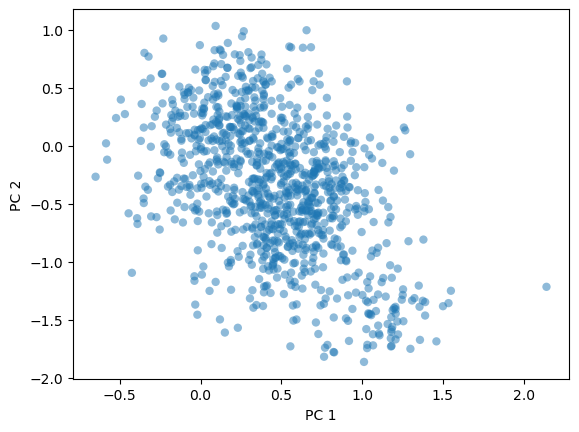

In [74]:
plt.scatter(Xproj_gen[:, 0], Xproj_gen[:, 1], alpha = 0.5, edgecolor='none')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
#plt.savefig('PCA_artificial.png', dpi=600)
plt.show()

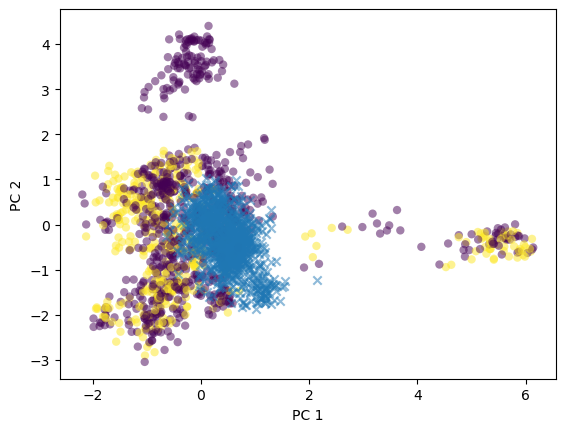

In [75]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, alpha = 0.5, edgecolor='none')
plt.scatter(Xproj_gen[:, 0], Xproj_gen[:, 1], alpha = 0.5, marker='x')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig('PCA_generated.png', dpi=600)
plt.show()